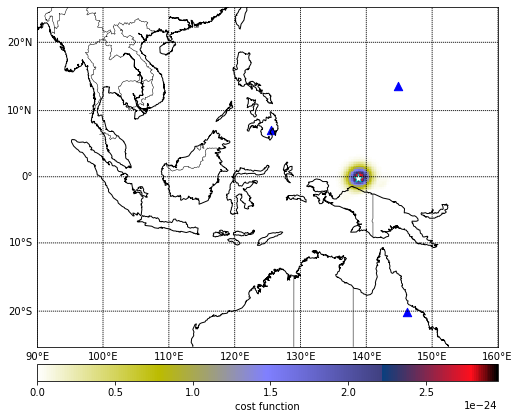

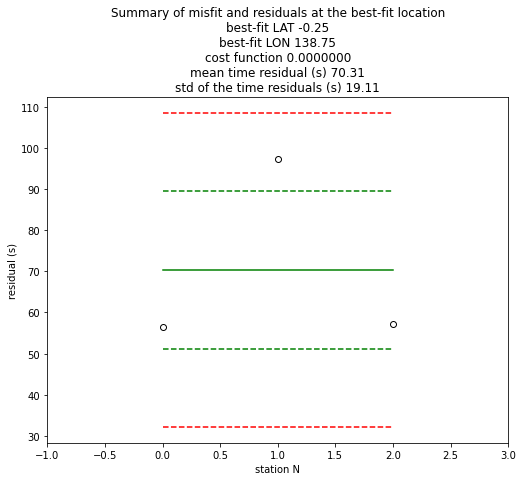

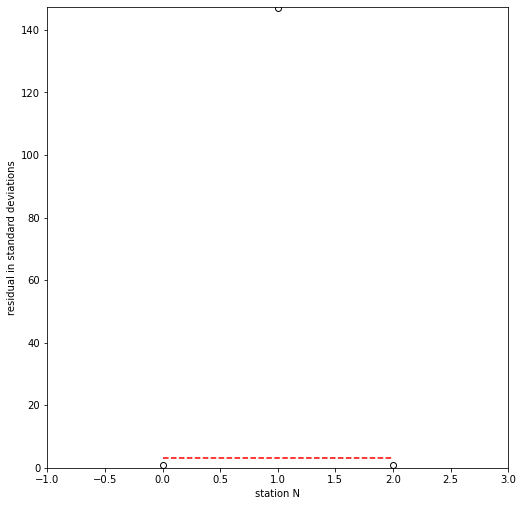

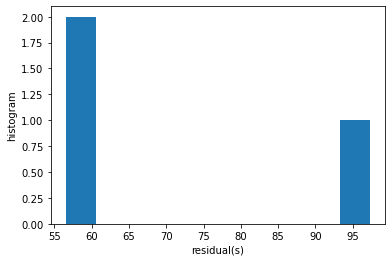

In [2]:
from mpl_toolkits.basemap import Basemap, cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from scipy.interpolate import interp1d


plt.close("all")

#---------------------------------------
# function degrees to radians
#---------------------------------------
def radians(degree) : 
    rad = degree * np.pi / 180
    return rad
#---------------------------------------

#---------------------------------------
# function (a,c,dlat,dlon)=haversine(lat1,lon1,lat2,lon2)
# HAVERSINE_FORMULA.AWK - converted from AWK 
#---------------------------------------
def haversine(lat1,lon1,lat2,lon2) :
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2
    c = 2 * np.arcsin(np.sqrt(a))
    return (a,c,dlat,dlon)
#---------------------------------------

#---------------------------------------
# function spherical distance
#---------------------------------------
def sp_dist_deg(lat1,lon1,lat2,lon2) :
    (a,c,dlat,dlon)=haversine(lat1,lon1,lat2,lon2)
    dist = 180*c/np.pi
    return dist
#---------------------------------------

#---------------------------------------
# function reading travel times from file 
#---------------------------------------
def read_spttimes(psfname) :
    p1 = []
    p4 = []
    p5 = []
    with open(psfname,'r') as fps:
        lines = fps.readlines()
    for line in lines:
        p = line.split()
        p1.append(float(p[0]))
        p4.append(float(p[3]))
        p5.append(float(p[4]))
    d = np.array(p1)
    tsp = 60*np.array(p4) + np.array(p5)
    return(d,tsp)
#-----------------------------------------------

(delta_ref, t_s_p_ref) = read_spttimes('p_s_600.dat')

#-----------------------------------------------
# defining S-P time function
#-----------------------------------------------
t_s_p = interp1d(delta_ref, t_s_p_ref)
#-----------------------------------------------


#---------------------------------------
# function computing cost function
#---------------------------------------
def cost_f(la,lo,stla,stlo,s_p_obs,sigma):
    d_st = sp_dist_deg(la,lo,stla,stlo)
    s_p = t_s_p(d_st)
    ns = s_p_obs.size
    cf1 = np.sum(((s_p-s_p_obs)**2))/(ns*sigma**2)
    cf2 = np.exp(-1/2.*np.sum(((s_p-s_p_obs)**2))/(ns*sigma**2))
    cf3 = np.sum(np.exp(-1/2.*((s_p-s_p_obs)**2)/(sigma**2)))/ns
    return (cf1,cf2,cf3)
#---------------------------------------




#-----------------------------------------------
# stations, coordiantes and S-P times
#-----------------------------------------------

la = []
lo = []
sp = []

#-------------------
# !!! This is the place where you have to introduce travel time differences 
# measured from SAC files
#-------------------
#DAV
la.append(7.069700e+00)
lo.append(1.255791e+02)
sp.append(100.)             # !!! this is not a correct value
                            # replace it with one from SAC files

                            # progressively uncomment the following lines
                            # to intoroduce more data

#CTAO
la.append(-2.008820e+01)
lo.append(1.462545e+02)
sp.append(100)
#GUMO
la.append(1.358930e+01)
lo.append(1.448684e+02)
sp.append(100)
"""
#HKPS
la.append(2.227760e+01)
lo.append(1.141415e+02)
sp.append()
#QIZ
la.append(1.902910e+01)
lo.append(1.098445e+02)
sp.append()
#SSE
la.append(3.109480e+01)
lo.append(1.211908e+02 )
sp.append()
#KAPI
la.append(-5.014200e+00)
lo.append(1.197517e+02)
sp.append()
#WRAB
la.append(-1.993360e+01)
lo.append(1.343600e+02)
sp.append()
#MBWA
la.append(-2.115900e+01)
lo.append(1.197313e+02)
sp.append()
"""

laS = np.array(la)
loS = np.array(lo)
s_p_obs = np.array(sp)
#-----------------------------------------------


#-----------------------------------------------
# defining region and grid
#-----------------------------------------------
lamin = -25.
lamax = 25.
lomin = 90.
lomax = 160.


#--------------
dla = 0.25
dlo = 0.25

nla = int((lamax-lamin)/dla) + 1
nlo = int((lomax-lomin)/dlo) + 1

lamax = lamin + (nla-1)*dla
lomax = lomin + (nlo-1)*dlo

mf1 = np.zeros((nlo, nla))
mf2 = np.zeros((nlo, nla))
mf3 = np.zeros((nlo, nla))
lam = np.zeros((nlo, nla))
lom = np.zeros((nlo, nla))

#-----------------------------------------------
# computing misfit function on the grid
#-----------------------------------------------

for ilo in range(0, nlo):
    for ila in range(0, nla):
        lom[ilo,ila] = lomin + ilo*dla
        lam[ilo,ila] = lamin + ila*dlo
        (mf1[ilo,ila],mf2[ilo,ila],mf3[ilo,ila]) = cost_f(lam[ilo,ila],lom[ilo,ila],laS,loS,s_p_obs,7)
        
mf = mf2


        
# position of best fit
epicenter = np.where(mf == mf.max())
laE = lam[epicenter]
loE = lom[epicenter]
mfE = mf[epicenter]

#-----------------------------------------------
# plotting results on a map
#-----------------------------------------------

fig1 = plt.figure(1,figsize=(8,8))
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

lo0 = (lomin+lomax)/2
la0 = (lamin+lamax)/2

m = Basemap(projection='merc',\
            llcrnrlat=lamin,urcrnrlat=lamax,\
            llcrnrlon=lomin,urcrnrlon=lomax,\
            resolution='l',area_thresh=10000)

# draw coastlines, state and country boundaries, edge of map.
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(-90.,90,10.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0.,360.,10.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

# draw colormap
gx, gy = m(lom, lam)

my_cmap = plt.cm.gist_stern_r
#my_cmap = plt.cm.gist_ncar_r
#cs = m.contourf(gx,gy,mf,clevs,cmap=my_cmap)
cs = m.pcolor(gx,gy,mf,cmap=my_cmap)

# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('cost function')

# plotting stations
xst, yst = m(loS,laS)
m.scatter(xst,yst,70,marker='^',color='b')

# plotting stations
xe, ye = m(loE,laE)
m.scatter(xe,ye,75,marker='*',color='c')
m.scatter(xe,ye,20,marker='*',color='w')


#-----------------------------------------------
# plotting residuals at the best fit position
#-----------------------------------------------
d= sp_dist_deg(laE,loE,laS,loS)
resid = t_s_p(d) - s_p_obs
mean_resid = np.mean(resid)
std_resid = np.std(resid)

midline = resid-resid + mean_resid
maxline1 = midline + std_resid
maxline2 = midline + 2*std_resid
minline1 = midline - std_resid
minline2 = midline - 2*std_resid

#---------------------------------------
fig2 = plt.figure(2, figsize=(8,8))
ax = fig2.add_axes([0.1,0.1,0.8,0.6])

plt.plot(resid,'ok', mfc='none')
plt.plot(midline,'g')
plt.plot(maxline1,'g--')
plt.plot(maxline2,'r--')
plt.plot(minline1,'g--')
plt.plot(minline2,'r--')
plt.xlim(-1,np.size(resid))
plt.xlabel('station N')
plt.ylabel('residual (s)')
plt.title('Summary of misfit and residuals at the best-fit location\n\
best-fit LAT %.2f\n\
best-fit LON %.2f\n\
cost function %.7f\n\
mean time residual (s) %.2f\n\
std of the time residuals (s) %.2f' % (laE, loE, mfE, mean_resid, std_resid) )



#-----------------------------------------------
# analyzing residuals for outliers
#-----------------------------------------------
nr = np.size(resid)

out = np.zeros(nr)

num = np.arange(nr)

for i in range(0, nr):
    numi = num != i
    m = np.mean(resid[numi])
    s = np.std(resid[numi])
    out[i] = np.fabs(resid[i]-m)/s

maxline = resid-resid + 3.
ymax = np.max((np.max(out),3)) +.25

#-----------------------------------------------
# plotting residuals norimalized with starndard deviations (of the  dataset not including them)
fig3 = plt.figure(3, figsize=(8,8))
ax = fig3.add_axes([0.1,0.1,0.8,0.8])

plt.plot(out,'ok', mfc='none')
plt.plot(maxline,'r--')
plt.xlim(-1,nr)
plt.ylim(0,ymax)
plt.xlabel('station N')
plt.ylabel('residual in standard deviations')

#-----------------------------------------------
# histogram of residuals
fig4 = plt.figure(4)
plt.hist(resid)
plt.ylabel('histogram')
plt.xlabel('residual(s)')

plt.show()
